# Assignment 2 - Sound Recognition

## 1. Pre-processing: Load All Recordings, Median Filter, and FFT

In [2]:
import librosa
import glob
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

from scipy.fftpack import fft
from scipy import signal

In [3]:
def load_data(classes):
    class Audios():
        f= None
        fs= None
        # xf= None # used to plot picture
        # yf= None # used to plot picture
        tag= None
    tags=[]
    data=[]
    med_filt_kernel = 3

    for i_class in classes:
        for each_file in glob.glob("Dataset/"+i_class+"/*.wav"):
            audio=Audios()
            f, fs=librosa.load(each_file, sr=None, mono=True, offset=0.0, duration=None) # load file
            f = signal.medfilt(f, kernel_size=med_filt_kernel) # median filter with zero padding 
            audio.f= f
            audio.fs= fs
            audio.tag=i_class
            tags.append(audio.tag)
            data.append(audio)
    return data, tags

In [4]:
classes = ["Alarm", "Silence", "Music", "Microwave", "Clean", "Blender"]
data, tags = load_data(classes)

## 2. Model Building 

In [5]:
import cv2

from numpy.lib.stride_tricks import sliding_window_view
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn import preprocessing



## 2.1 Binning Models 

### 2.1.1 Windowing

#### I. Cut into windows and combine windows to get sample features

In [6]:
def cutting_into_windows(sample, sample_fs):
    """Cutting sample into windows, every is 6s"""
    window_size = int(sample_fs * 4)# 6s instances/window
    window_overlap = window_size // 2
    windows = []
    i = 0
    win_count = 0
    while ((i + window_size) < len(sample)) and (win_count < 12):
        windows.append(sample[i: i + window_size])
        i = i + window_size - window_overlap
        win_count = win_count + 1
    return np.array(windows)

In [7]:
def get_window_features(FFT_SIZE, num_freq_bins, num_time_bins, data):
    """Obtain all data's features, shape=(num_data, window_num * num_freq_bins * num_time_bins"""
    
    features=[]
    for sample in data:
        windows = cutting_into_windows(sample.f, sample.fs)
        sample_features = []
        for window in windows:
            f,t,pxx = signal.spectrogram(window, nperseg=FFT_SIZE, fs=sample.fs, noverlap=int(FFT_SIZE/4))
            resize_pxx=cv2.resize(pxx[:,:],(num_time_bins,num_freq_bins))
        
            sample_features.append(resize_pxx.reshape(-1, ))
            pass
        features.append(np.array(sample_features).reshape(-1, ))
    features = np.array(features)
    return features
    

#### II. Training and Save Model

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay
import joblib


/Users/fji1/opt/anaconda3/envs/machinelearning/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


Average Cross Validation Score from Training:
0.9777777777777779


Confusion Matrix:
[[ 2  0  0  0  0  0]
 [ 0  5  0  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  6  0]
 [ 0  0  0  0  0 12]]


Test Statistics:
              precision    recall  f1-score   support

       Alarm       1.00      1.00      1.00         2
     Blender       1.00      1.00      1.00         5
       Clean       1.00      1.00      1.00         7
   Microwave       1.00      1.00      1.00         4
       Music       1.00      1.00      1.00         6
     Silence       1.00      1.00      1.00        12

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



Testing Accuracy: 1.0


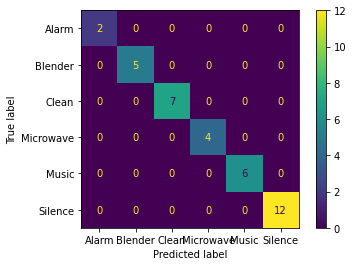

['Model/bin_window.joblib']

In [9]:
FFT_SIZE=1024
num_freq_bins=20
num_time_bins=20

bin_window_features = get_window_features(FFT_SIZE, num_freq_bins, num_time_bins, data)
scaler = preprocessing.StandardScaler()
bin_window_features = scaler.fit_transform(bin_window_features)


xtrain, xtest, ytrain, ytest = train_test_split(bin_window_features, tags, test_size=0.3, random_state=100)
clf = RandomForestClassifier(random_state=100)
# clf = SVC()
clf.fit(xtrain, ytrain)
ypred = clf.predict(xtrain)

scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print('Average Cross Validation Score from Training:', scores.mean(), sep='\n', end='\n\n\n')

#testing the model
ypred = clf.predict(xtest)

cm = confusion_matrix(ytest, ypred)
cr = classification_report(ytest, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

print('Testing Accuracy:', accuracy_score(ytest, ypred))
names = ["Alarm", "Blender", "Clean", "Microwave", "Music", "Silence"]
cm_display = ConfusionMatrixDisplay(cm, display_labels=names)
cm_display.plot()
plt.savefig("Pictures/bin_window_test_cf.png")
plt.show()

joblib.dump(clf, "Model/bin_window.joblib")

### 2.1.2 No windowing

In [10]:
from sklearn import preprocessing


In [11]:
def get_no_window_features(FFT_SIZE, num_freq_bins, num_time_bins, data):
    """Obtain all data's features, shape=(num_data, window_num * num_freq_bins * num_time_bins"""
    
    features=[]
    for sample in data:
        f,t,pxx = signal.spectrogram(sample.f, nperseg=FFT_SIZE, fs=sample.fs, noverlap=int(FFT_SIZE/4))
        resize_pxx=cv2.resize(pxx[:,:],(num_time_bins,num_freq_bins))
    
        features.append(resize_pxx.reshape(-1, ))
        pass
    features = np.array(features)
    return features

Average Cross Validation Score from Training:
0.9888888888888889


Testing Accuracy: 1.0
Confusion Matrix:
[[7 0 0 0 0 0]
 [0 5 0 0 0 0]
 [0 0 7 0 0 0]
 [0 0 0 4 0 0]
 [0 0 0 0 7 0]
 [0 0 0 0 0 6]]


Test Statistics:
              precision    recall  f1-score   support

       Alarm       1.00      1.00      1.00         7
     Blender       1.00      1.00      1.00         5
       Clean       1.00      1.00      1.00         7
   Microwave       1.00      1.00      1.00         4
       Music       1.00      1.00      1.00         7
     Silence       1.00      1.00      1.00         6

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



Testing Accuracy: 1.0


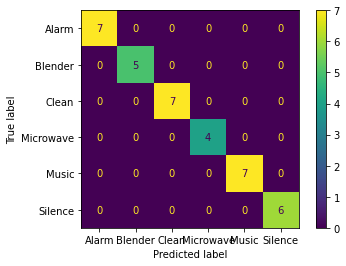

['Model/bin_no_window.joblib']

In [12]:
num_freq_bins=50
num_time_bins=50

bin_no_window_feature = get_no_window_features(FFT_SIZE, num_freq_bins, num_time_bins, data)

scaler = preprocessing.StandardScaler()
bin_no_window_feature = scaler.fit_transform(bin_no_window_feature)

xtrain, xtest, ytrain, ytest = train_test_split(bin_no_window_feature, tags, test_size=0.30,random_state=200)


clf = RandomForestClassifier(random_state=200)
clf.fit(xtrain, ytrain)
cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

#testing the model
ypred = clf.predict(xtest)
cm = confusion_matrix(ytest, ypred)
cr = classification_report(ytest, ypred)

print('Testing Accuracy:', accuracy_score(ytest, ypred))

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

print('Testing Accuracy:', accuracy_score(ytest, ypred))
names = ["Alarm", "Blender", "Clean", "Microwave", "Music", "Silence"]
cm_display = ConfusionMatrixDisplay(cm, display_labels=names)
cm_display.plot()
plt.savefig("Pictures/bin_no_window_test_cf.png")
plt.show()

joblib.dump(clf, "Model/bin_no_window.joblib")

## 2.2 Domain Specific Models

### 2.2.1 Windowing

#### I. Cut into windows and combine windows to get sample features

Cutting windows is already appeared before, so just utilize

In [13]:
domain_window_features=[]
for sample in data:
    windows = cutting_into_windows(sample.f, sample.fs)
    sample_features = []
    for window in windows:
        mfccs=librosa.feature.mfcc(y=window,sr=sample.fs,n_mfcc=20)
        mfccs=np.mean(mfccs.T, axis=0)
        sample_features.append(mfccs.reshape((-1, ))) 
    sample_features = np.array(sample_features).reshape((-1, ))
    domain_window_features.append(sample_features)
domain_window_features = np.array(domain_window_features)


Average Cross Validation Score from Training:
1.0


Confusion Matrix:
[[7 0 0 0 0 0]
 [0 7 0 0 0 0]
 [0 0 4 0 0 0]
 [0 0 0 7 0 0]
 [0 0 0 0 5 0]
 [0 0 0 0 0 6]]


Test Statistics:
              precision    recall  f1-score   support

       Alarm       1.00      1.00      1.00         7
     Blender       1.00      1.00      1.00         7
       Clean       1.00      1.00      1.00         4
   Microwave       1.00      1.00      1.00         7
       Music       1.00      1.00      1.00         5
     Silence       1.00      1.00      1.00         6

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



Testing Accuracy: 1.0


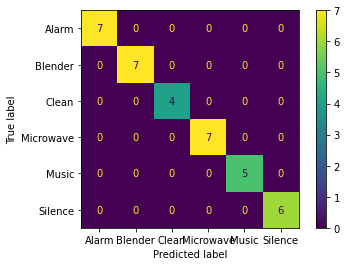

['Model/domain_window.joblib']

In [14]:

#training the model
xtrain, xtest, ytrain, ytest = train_test_split(domain_window_features, tags, test_size=0.30,random_state=300)

# clf = SVC(kernel='linear') #note the default kernel here is 'rbf' - radial basis function
clf = RandomForestClassifier(random_state=300)
clf.fit(xtrain, ytrain)
cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

#testing the model
ypred = clf.predict(xtest)
cm = confusion_matrix(ytest, ypred)
cr = classification_report(ytest, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')
print('Testing Accuracy:', accuracy_score(ytest, ypred))
names = ["Alarm", "Blender", "Clean", "Microwave", "Music", "Silence"]

cm_display = ConfusionMatrixDisplay(cm, display_labels=names)
cm_display.plot()
plt.savefig("Pictures/domain_window_test_cf.png")
plt.show()

joblib.dump(clf, "Model/domain_window.joblib")

### 2.2.2 No windowing

In [15]:
domain_no_window_feature=[]

for sample in data:
    mfccs=librosa.feature.mfcc(y=sample.f,sr=sample.fs,n_mfcc=40)
    mfccs=np.mean(mfccs.T, axis=0)
    domain_no_window_feature.append(mfccs.reshape((-1, )))
domain_no_window_feature = np.array(domain_no_window_feature)


Average Cross Validation Score from Training:
1.0


Confusion Matrix:
[[7 0 0 0 0 0]
 [0 7 0 0 0 0]
 [0 0 6 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 6 0]
 [0 0 0 0 0 5]]


Test Statistics:
              precision    recall  f1-score   support

       Alarm       1.00      1.00      1.00         7
     Blender       1.00      1.00      1.00         7
       Clean       1.00      1.00      1.00         6
   Microwave       1.00      1.00      1.00         5
       Music       1.00      1.00      1.00         6
     Silence       1.00      1.00      1.00         5

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



Testing Accuracy: 1.0


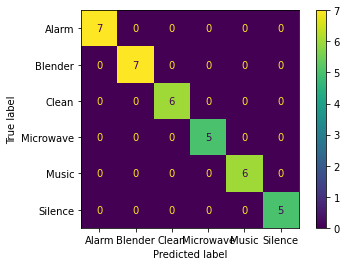

['Model/domain_no_window.joblib']

In [16]:
xtrain, xtest, ytrain, ytest = train_test_split(domain_no_window_feature, tags, test_size=0.30,random_state=600)
#clf = SVC()
# clf = SVC(kernel="linear", degree=2)
clf = RandomForestClassifier(random_state=600)
clf.fit(xtrain, ytrain)
cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

#testing the model
ypred = clf.predict(xtest)
cm = confusion_matrix(ytest, ypred)
cr = classification_report(ytest, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

print('Testing Accuracy:', accuracy_score(ytest, ypred))

names = ["Alarm", "Blender", "Clean", "Microwave", "Music", "Silence"]

cm_display = ConfusionMatrixDisplay(cm, display_labels=names)
cm_display.plot()
plt.savefig("Pictures/domain_no_window_test_cf.png")
plt.show()

joblib.dump(clf, "Model/domain_no_window.joblib")

## Real-Time Predictions 

### Calling Model and Predicting

In [17]:
import pyaudio
import wave

ModuleNotFoundError: No module named 'pyaudio'

In [ ]:
loaded_model = joblib.load("Model/domain_no_window.joblib")

CHUNK=1024
FORMAT=pyaudio.paInt16
CHANNELS=1
RATE=48000

p=pyaudio.PyAudio()
stream=p.open(format=FORMAT,channels=CHANNELS,rate=RATE,input=True,frames_per_buffer=CHUNK)
print("start recording...")
frames=[]
seconds=15
for i in range (0,int(RATE/CHUNK*seconds)):
	data=stream.read(CHUNK)
	frames.append(data)
	
print("recording stopped")
stream.stop_stream()
stream.close()
p.terminate()

wf=wave.open("output.wav","wb")
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

A,fs=librosa.load("./output.wav", sr=None, mono=True, offset=0.0, duration=None)
mfccs=librosa.feature.mfcc(y=A,sr=fs,n_mfcc=40)
mfccs=np.mean(mfccs.T, axis=0)
y_pred=clf.predict(np.array([mfccs]))

print(y_pred)

start recording...
recording stopped
['Silence']
